# Histopathologic Cancer Detection

## Introduction
The workflow is heavily inspired by https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing.

Totally, 160,000 images that include 144,000 training images and 16,000 validation images are used to train the model1. The folder structure

This is achieved by organizing a folder structure and utilizing generators to feed data to the model1 for training, validation, and prediction.

Note: GPU helps facilitate creating folder structures. Turn on the GPU before creating any folder structure in output directory

## 1. Import Related Library

In [51]:
from numpy.random import seed
seed(77)

import os
import shutil

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## 2. Exploratory Data Analysis

In [22]:
# Define the data path
data_path = '/kaggle/input/histopathologic-cancer-detection'
input_train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')
label_path = os.path.join(data_path, 'train_labels.csv')

In [23]:
os.listdir(data_path)

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

The number of train and test data points

In [24]:
print('Labeled Data Size: ',len(os.listdir(input_train_path)))
print('Test Data Size:', len(os.listdir(test_path)))

Labeled Data Size:  220025
Test Data Size: 57458


In [25]:
df_data = pd.read_csv(label_path)

# removing this image because it caused a training error previously
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print('train_df_shape',df_data.shape)
df_data.head()

train_df_shape (220023, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Category Distribution of the data. Zero indicate no tumor tissue and one indicates having tumor tissue

In [26]:
df_data['label'].value_counts()

label
0    130907
1     89116
Name: count, dtype: int64

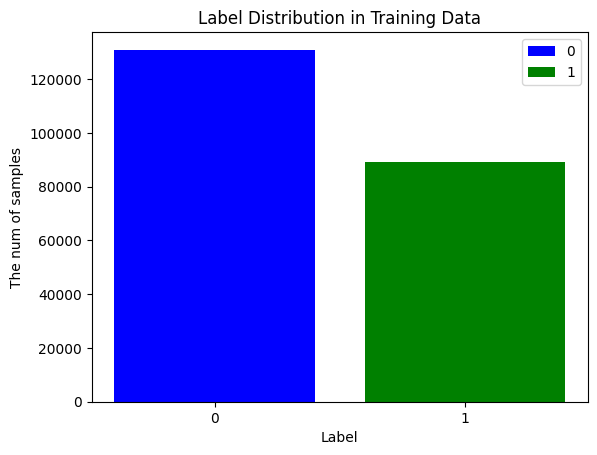

In [27]:
plt.bar([0, 1],df_data['label'].value_counts(), label = [0, 1], color = ['blue', 'green'])
plt.title('Label Distribution in Training Data')
plt.xticks([1,0])
plt.xlabel('Label')
plt.ylabel('The num of samples')
plt.legend()

In [28]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):

    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """


    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols,
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=os.path.join(IMAGE_PATH, sample.iloc[j]['id'] + '.tif')
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)
    plt.tight_layout()
    plt.show()

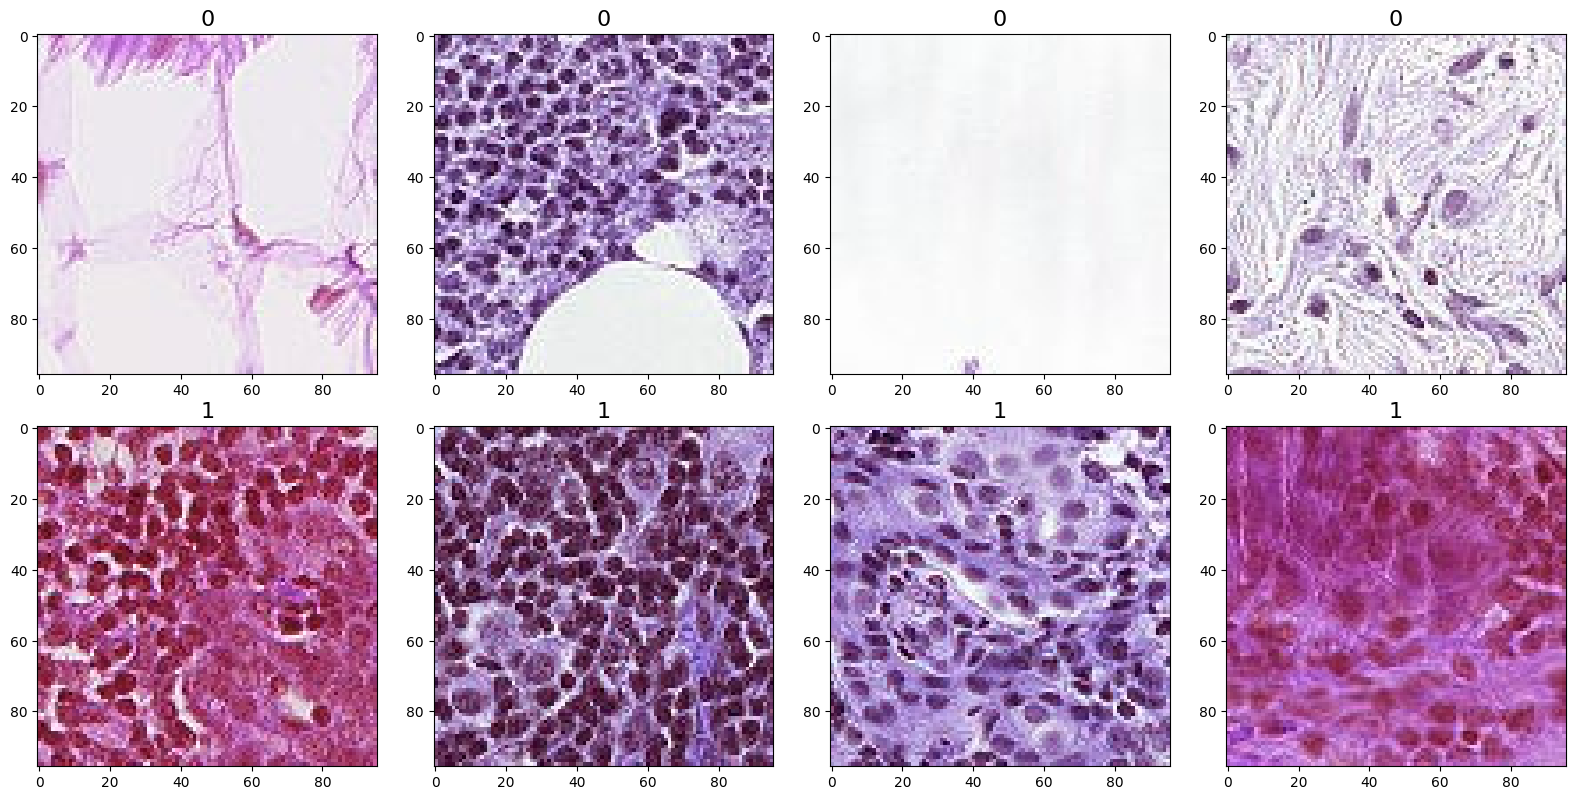

In [29]:
image_path = input_train_path
draw_category_images('label', 4, df_data, image_path)

## 3. Split Data into train and valid datasets

In [30]:
SAMPLE_SIZE = 80000 # load 80k examples for each class

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))

# train_test_split # stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

In [31]:
print('Train Data Distribution:',df_train['label'].value_counts())
print('Validation Data Distribution:',df_val['label'].value_counts())

Train Data Distribution: label
0    72000
1    72000
Name: count, dtype: int64
Validation Data Distribution: label
0    8000
1    8000
Name: count, dtype: int64


In [32]:
df_data.head()

,id,label
33530,e78700e6c2988f83c50f5ddb56d6d128d431ffe7,0
25375,d700d91efc581057f78b592025bcc0c3cf0212bd,0
24934,e65417a5f34a8c3f9ad361342d1d43f117a2a88a,0
65625,ad2b956019f85249cecc2460e93ed1f6f662191c,0
88490,36b909f7d2daf936ed5d9c3530e9a2a81078bfda,1


In [33]:
# Set the id as the index in df_data
df_data.set_index('id', inplace = True)

## 4. Create folders for train and valid datasets

In [34]:
# Create directories
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/valid_dir'
for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf))

In [35]:
for image in df_train['id'].values:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join(input_train_path, fname)
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)

for image in df_val['id'].values:
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join(input_train_path, fname)
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)

In [36]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/0')))
print(len(os.listdir('base_dir/train_dir/1')))

72000
72000


In [37]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/valid_dir/0')))
print(len(os.listdir('base_dir/valid_dir/1')))

8000
8000


Set up the image generator (update with tf.data)

In [38]:
IMAGE_SIZE = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size) 
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [39]:
print(train_steps)
print(val_steps)

4500.0
500.0


## 5. Build and Train the model1

I have referenced the following CNN architecture

https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb?scriptVersionId=7784920

model1 structure (optimizer: Adam):
* In
* [Conv2D*3 -> MaxPool2D -> Dropout] x3 --> (The number of 3x3 filters = 32, 64, 128)
* Flatten
* Dense (256)
* Dropout
* Out

The model1 architecture consists of three blocks. In each block, the model1 structure uses three 2D convolution filtering layers. Next, the maxpool is utilized to reduce the dimensions of the feature map. At the end, it also uses dropout to reduce overfitting. The activation function used in the oncolution layers is ReLU.

### Model 1: 3 Blocks of Filters with MaxPooling and Dropout

**Kernel Size:** 3x3 for each filter

**Number of filters:** 32 x 3 -> 64 x 3 -> 128 x 3, three blocks

**Conv2D:** Apply above kernel in Convolution 2D package

**MaxPooling:** For each block, after the convolution 2D, apply MaxPooling with pool size 2x2

**Dropout:** For each block, after the convolution 2D, apply a dropout of 30%. Another dropout apply after finishing above three blocks.

**Activation:** Use Rectified Linear Unit (ReLU) function in each block. For the output layer, sigmoid with one unit output which yield a probability of positive class is used

**Optimizer:** Adaptive Moment Estimation is used when compile the model.


In [40]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model1 = Sequential()
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(MaxPooling2D(pool_size = pool_size)) 
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(dropout_dense))
model1.add(Dense(1, activation = "sigmoid"))

model1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,660,929 (6.34 MB)

 Trainable params: 1,660,929 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Compile the model
model1.compile(Adam(0.001), loss = "binary_crossentropy", metrics=["accuracy"])

In [42]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'0': 0, '1': 1}


In [44]:
# filepath = "model1.keras"
# checkpoint = model1Checkpoint(filepath, monitor='val_acc', verbose=1, 
#                              save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 2, 
                           verbose = 1, mode = 'max', restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [early_stop, reduce_lr]

# history = model1.fit(train_gen, steps_per_epoch=int(train_steps), 
#                     validation_data=val_gen,
#                     validation_steps=int(val_steps),
#                     epochs=10, verbose=1,
#                    callbacks=callbacks_list)

history1 = model1.fit(train_gen, 
                    validation_data=val_gen,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 179s 40ms/step - accuracy: 0.7581 - loss: 0.4953 - val_accuracy: 0.8577 - val_loss: 0.3332 - learning_rate: 0.0010
Epoch 2/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 177s 39ms/step - accuracy: 0.8525 - loss: 0.3443 - val_accuracy: 0.8806 - val_loss: 0.2881 - learning_rate: 0.0010
Epoch 3/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 174s 39ms/step - accuracy: 0.8703 - loss: 0.3125 - val_accuracy: 0.8807 - val_loss: 0.2846 - learning_rate: 0.0010
Epoch 4/10
4498/4500 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8750 - loss: 0.3001
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 177s 39ms/step - accuracy: 0.8750 - loss: 0.3001 - val_accuracy: 0.8789 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 5/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 176s 39ms/step - accuracy: 0.8934 - loss: 0.2632 - val_accuracy: 0.9069 - val_loss: 0.2351 - learning_rate: 5.0000e-04
Epoch 6/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 176s 39ms/step 

Text(0, 0.5, 'Accuracy/Loss')

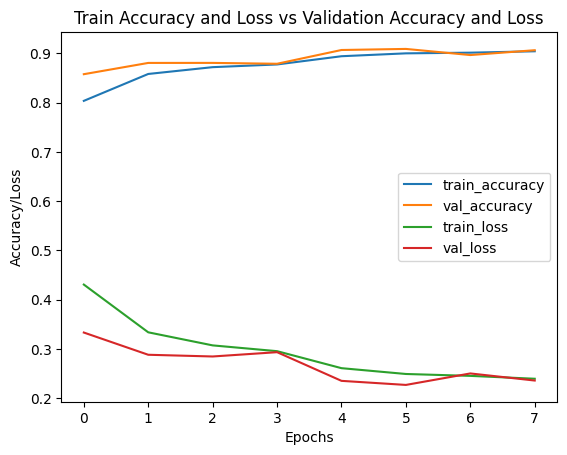

In [45]:
model1_hist = pd.DataFrame(model1.history.history)
model1_hist = model1_hist.rename(columns = {'accuracy': 'train_accuracy', 'loss': 'train_loss'})
model1_hist[['train_accuracy','val_accuracy','train_loss', 'val_loss']].plot()
plt.title('Train Accuracy and Loss vs Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')

In [46]:
max_val_acc1 = model1_hist.val_accuracy.max()
print('Maximum Validation Acc:', round(max_val_acc1 * 100, 2), "%")
min_val_loss1 = model1_hist.val_loss.min()
print('Minimum Validation Loss:', round(min_val_loss1 * 100, 2), "%")

Maximum Validation Acc: 90.91 %
Minimum Validation Loss: 22.69 %


Model1 performs pretty well with the maximum validation accurcy over 90% and loss under 23%.

In [47]:
# Save the model
model1.save('model1.keras')

#### Plot ROC Curve

In [48]:
# make a prediction on validation set
test_label = test_gen.classes
y_pred_keras1 = model1.predict(test_gen, steps=len(df_val), verbose=1)
fpr_keras1, tpr_keras1, thresholds_keras1 = roc_curve(test_label, y_pred_keras1)
auc_keras1 = auc(fpr_keras1, tpr_keras1)
print('Area under ROC curve: ', auc_keras1)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16000/16000 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step
Area under ROC curve:  0.9690593828124998


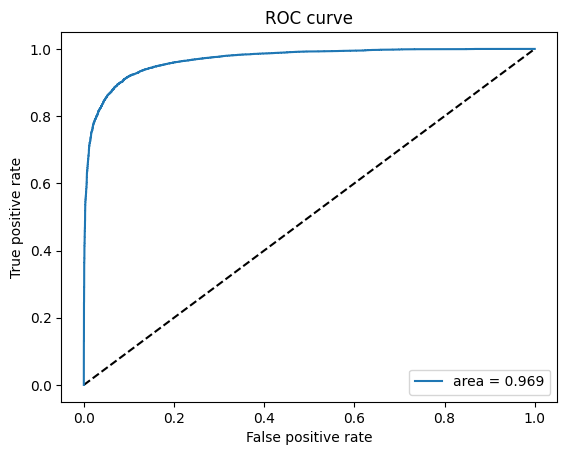

In [49]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras1, tpr_keras1, label='area = {:.3f}'.format(auc_keras1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Plot Confusion Matrix

In [56]:
# Convert probabilty to 0 or 1
yp1 = [1 if yp >= 0.5 else 0 for yp in y_pred_keras1]

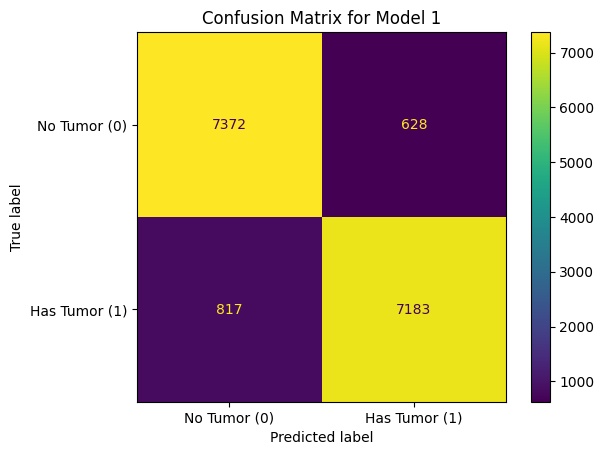

In [59]:
labels = ['No Tumor (0)', 'Has Tumor (1)']
cm = confusion_matrix(test_label, yp1)
cmd = ConfusionMatrixDisplay(cm, display_labels = labels)
cmd.plot()
plt.title('Confusion Matrix for Model 1')
plt.grid(False)
plt.show()

The model1 predicts "No tumor" better than "Has tumor" as it the model miss predicted 628 "No Tumor" and 817 "Has Tumor" per confusion matrix. While having relatively higher positive rate is concerning in terms of tumor diagnosis.

### Model 2: 3 Blocks of Filters with MaxPooling and Batch Normalization
Instead of using dropout following each convolution 2D block, use batch normalization. Only a single dropout afte the last block is applied.

**Kernel Size:** 3x3 for each filter

**Number of filters:** 32 x 3 -> 64 x 3 -> 128 x 3, three blocks

**Conv2D:** Apply above kernel in Convolution 2D package

**MaxPooling:** For each block, after the convolution 2D, apply MaxPooling with pool size 2x2

**Batch Normalization:** For each block, after the convolution 2D, apply a Batch Normalization to prevent overfitting

**Activation:** Use Rectified Linear Unit (ReLU) function in each block. For the output layer, sigmoid with one unit output which yield a probability of positive class is used

**Optimizer:** Adaptive Moment Estimation is used when compile the model.

In [60]:
kernel_size = (3,3)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_dense = 0.3


model2 = Sequential()
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model2.add(MaxPooling2D(pool_size = pool_size)) 
model2.add(BatchNormalization())

model2.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model2.add(MaxPooling2D(pool_size = pool_size))
model2.add(BatchNormalization())

model2.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model2.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model2.add(MaxPooling2D(pool_size = pool_size))
model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dropout(dropout_dense))
model2.add(Dense(1, activation = "sigmoid"))

model2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 45, 45, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 19, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,825 (6.34 MB)

 Trainable params: 1,661,377 (6.34 MB)

 Non-trainable params: 448 (1.75 KB)

In [61]:
# Compile the model
model2.compile(Adam(0.001), loss = "binary_crossentropy", metrics=["accuracy"])

In [62]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 2, 
                           verbose = 1, mode = 'max', restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [early_stop, reduce_lr]

history2 = model2.fit(train_gen, 
                    validation_data=val_gen,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 188s 40ms/step - accuracy: 0.7732 - loss: 0.5437 - val_accuracy: 0.8378 - val_loss: 0.3741 - learning_rate: 0.0010
Epoch 2/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 181s 40ms/step - accuracy: 0.8572 - loss: 0.3394 - val_accuracy: 0.8905 - val_loss: 0.2791 - learning_rate: 0.0010
Epoch 3/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 178s 40ms/step - accuracy: 0.8846 - loss: 0.2881 - val_accuracy: 0.8961 - val_loss: 0.2779 - learning_rate: 0.0010
Epoch 4/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 177s 39ms/step - accuracy: 0.8958 - loss: 0.2630 - val_accuracy: 0.9123 - val_loss: 0.2215 - learning_rate: 0.0010
Epoch 5/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 179s 40ms/step - accuracy: 0.9045 - loss: 0.2449 - val_accuracy: 0.9093 - val_loss: 0.2464 - learning_rate: 0.0010
Epoch 6/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 179s 40ms/step - accuracy: 0.9119 - loss: 0.2288 - val_accuracy: 0.9163 - val_loss: 0.2115 - learning_rate: 0.0010
Epoch 7/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 178s 39ms/step -

Text(0, 0.5, 'Accuracy/Loss')

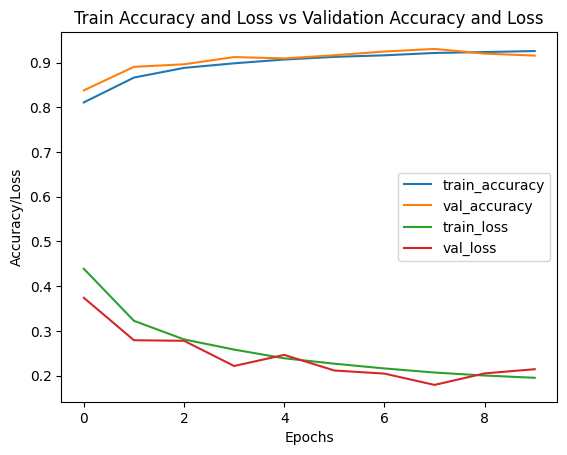

In [63]:
model2_hist = pd.DataFrame(model2.history.history)
model2_hist = model2_hist.rename(columns = {'accuracy': 'train_accuracy', 'loss': 'train_loss'})
model2_hist[['train_accuracy','val_accuracy','train_loss', 'val_loss']].plot()
plt.title('Train Accuracy and Loss vs Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')

In [64]:
max_val_acc2 = model2_hist.val_accuracy.max()
print('Maximum Validation Acc:', round(max_val_acc2 * 100, 2), "%")
min_val_loss2 = model2_hist.val_loss.min()
print('Minimum Validation Loss:', round(min_val_loss2 * 100, 2), "%")

Maximum Validation Acc: 93.05 %
Minimum Validation Loss: 17.92 %


Model2 performs better with the maximum validation accurcy over 93% and loss under 18%.

In [66]:
# Save the model
model2.save('model2.keras')

### Plot ROC Curve

In [67]:
# make a prediction on validation set
test_label = test_gen.classes
y_pred_keras2 = model2.predict(test_gen, steps=len(df_val), verbose=1)
fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(test_label, y_pred_keras2)
auc_keras2 = auc(fpr_keras2, tpr_keras2)
print('Area under ROC curve: ', auc_keras2)

16000/16000 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step
Area under ROC curve:  0.9798248437500001


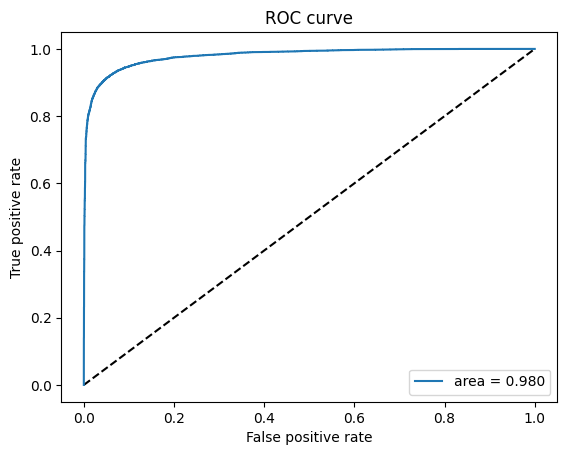

In [68]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras2, tpr_keras2, label='area = {:.3f}'.format(auc_keras2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Plot Confusion Matrix

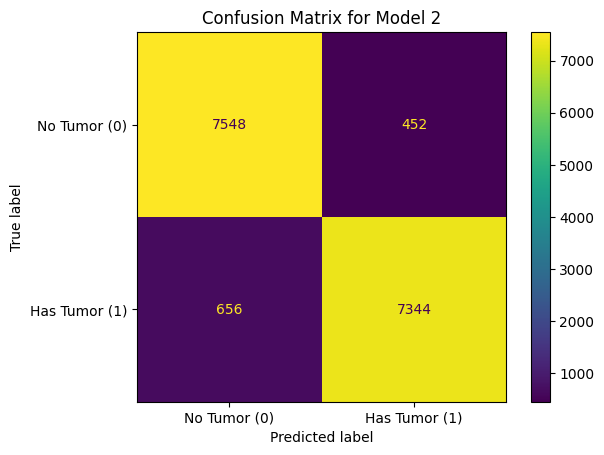

In [70]:
# Convert probabilty to 0 or 1
yp2 = [1 if yp >= 0.5 else 0 for yp in y_pred_keras2]

labels = ['No Tumor (0)', 'Has Tumor (1)']
cm2 = confusion_matrix(test_label, yp2)
cmd2 = ConfusionMatrixDisplay(cm2, display_labels = labels)
cmd2.plot()
plt.title('Confusion Matrix for Model 2')
plt.grid(False)
plt.show()

Similarly, the model2 predicts "No tumor" better than "Has tumor" as it the model miss predicted 452 "No Tumor" and 656 "Has Tumor" per confusion matrix. While having relatively higher positive rate is concerning in terms of tumor diagnosis. It has better performance than model 1. Therefore, I will use model2 to make a test prediction.

## 7. Make a Test Prediction

In [71]:
#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]

# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images) 
# inside another folder (test_dir).

# test_dir
    # test_images

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

FileExistsError: [Errno 17] File exists: 'test_dir'

In [72]:
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [73]:
# Transfer the test images into image_dir

test_list = os.listdir(test_path)

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join(test_path, fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [74]:
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))

57458

#### Set up the test generator

In [75]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [76]:
num_test_images = len(os.listdir('test_dir/test_images'))

# # make sure we are using the best epoch
# model1.load_weights(filepath)

predictions = model2.predict(test_gen, steps=num_test_images, verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 140s 2ms/step


In [77]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['label'])
df_preds.head()

,label
0,0.999997
1,0.908241
2,0.767214
3,0.013130
4,0.006844


In [78]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.

test_filenames = test_gen.filenames
test_filenames[0:5]

['test_images/00006537328c33e284c973d7b39d340809f7271b.tif',
 'test_images/0000ec92553fda4ce39889f9226ace43cae3364e.tif',
 'test_images/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif',
 'test_images/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif',
 'test_images/000270442cc15af719583a8172c87cd2bd9c7746.tif']

In [79]:
df_preds['id'] = test_gen.filenames

def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['id'].apply(extract_id)
# df_preds = df_preds.set_index('id')
df_preds.head()

,label,id
0,0.999997,00006537328c33e284c973d7b39d340809f7271b
1,0.908241,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.767214,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.013130,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.006844,000270442cc15af719583a8172c87cd2bd9c7746


In [80]:
submission = pd.DataFrame({'id': df_preds['id'],
                          'label': df_preds['label']}).set_index('id')
submission.to_csv("submission.csv") 

In [81]:
pd.read_csv('submission.csv')

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.999997
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.908241
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.767214
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.013130
4,000270442cc15af719583a8172c87cd2bd9c7746,0.006844
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0.001845
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0.035311
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0.000622
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0.479191
